# Predicting prematurity from MRI using CNN

In this notebook we will demonstrate how to train a **CNN classifier** to predict prematurity in newborn babies from 2D brain MRI slices. 

### GPU

For this task we will need a GPU with at least 4GB memory. First we check whether we have GPU locally and how much memory it has.

In [1]:
import torch

# Is GPU available?
torch.cuda.is_available()

True

If the answer is `True`, check the GPU memory

In [2]:
print(torch.cuda.get_device_properties('cuda:0'))

_CudaDeviceProperties(name='Quadro M2000', major=5, minor=2, total_memory=4096MB, multi_processor_count=6)


If the memory is 4096M (4GB) or more, you can run this example locally. If not you will need to upload this notebook to google colab.

### Google colab

Sign in to your google account. Then go to https://colab.research.google.com/. Click on the *Upload* tab and drag this notebook there. To access GPU, click on *Runtime->Change Runtime Type* and change *hardware accelerator* to *GPU*. If you rerun the two cells above, you should now find that you have access to cuda. You should also see your GPU memory, that at the time of writing 15GB.

If you are on Colab you also need to upload the dataset. Run the cell below and upload `neonatal_data.npz` that is available from this github repo https://github.com/MachineLearningBiomedicalApplications/notebooks.

In [3]:
# run this only if you use google colab

#from google.colab import files
#files.upload()

### Load the dataset

In [4]:
# Load dataset
import numpy as np
data = np.load('datasets/neonatal_data.npz')
# data = np.load('neonatal_data.npz') # alternative for google colab
data.files

['MR_images', 'prematurity']

In [5]:
# MRI - we have 157 images with size 64x64
mri = data['MR_images']
print(mri.shape)

(157, 1, 64, 64)


In [6]:
# Prematurity - binary labels
# 1 - preterm
# 0 - term
prem = data['prematurity']
print(prem.shape)

(157,)


In [7]:
# Proportion of preterm babies
np.around(np.sum(prem)/np.size(prem),2)

0.41

### Display the data

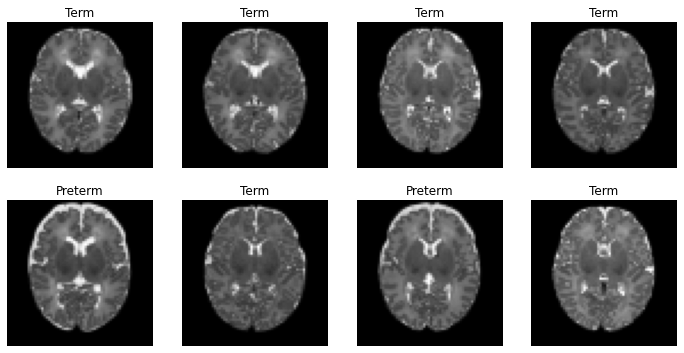

In [8]:
# Plot the first 8 images with prematurity status
from matplotlib import pyplot as plt
plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(mri[i,0,:,:],cmap='gray')
    if prem[i]:
        plt.title('Preterm')
    else:
        plt.title('Term')
    plt.axis('off')

### Prepare data for training

__Task 1:__ Convert data to Pytorch tensors. They are already in correct shape, but you need to convert the MRI data to `float` and prematurity to `long` in preparation for the classification task. 

In [9]:
import torch
X = torch.tensor(mri).float()
y = torch.tensor(prem).long()

__Task 2:__ Split the data into train, validation and test set. First remove 20% of the data for testing and then another 10% for validation. Stratify your split by the label.

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = \
    train_test_split(X_train, y_train, test_size=0.1,
                     stratify=y_train)
print('Training samples: ', y_train.size())
print('Validation samples: ', y_val.size())
print('Test samples: ', y_test.size())

Training samples:  torch.Size([112])
Validation samples:  torch.Size([13])
Test samples:  torch.Size([32])


### CNN architecture

Below you have the skeleton code for the CNN architecture that we will use in this example. It consists of three convolutional blocks and one fully connected block with two layers. 

__Task 3:__ Fill in the missing parameters for the CNN architecture. Here are some suggested parameters that you could use:
* numbers of outputs for CNN layers: 8, 16, 32
* numbers of outputs for FC layers: 32, 2
* Downsampling by two

Once you are happy you can run the cell. The code at the end will pass one MRI image through the network. This should produce the output with two elements, that correspond to logits for the two predicted classes.

In [11]:
import torch.nn as nn
# CNN architecture
class CNNclf(nn.Module):
    def __init__(self):
        super(CNNclf, self).__init__()

        self.conv_block1 = nn.Sequential(
             nn.Conv2d(1,8,3,padding=1),
             nn.BatchNorm2d(8),
             nn.ReLU(),
             nn.MaxPool2d(kernel_size=2,stride=2))
        self.conv_block2 = nn.Sequential(
             nn.Conv2d(8,16,3,padding=1),
             nn.BatchNorm2d(16),
             nn.ReLU(),
             nn.MaxPool2d(kernel_size=2,stride=2))
        self.conv_block3 = nn.Sequential(
             nn.Conv2d(16,32,3,padding=1),
             nn.BatchNorm2d(32),
             nn.ReLU(),
             nn.MaxPool2d(kernel_size=2,stride=2))
        self.fc_block = fc_block = nn.Sequential(
            nn.Linear(32*8*8, 32),
            nn.ReLU(),
            nn.Linear(32,2),
            nn.ReLU())

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = x.view(-1, 32*8*8)
        x = self.fc_block(x)
        return x
    
# Test the model
clf = CNNclf()
im = X[i,0,:,:].view(1,1,64,64)
print('input shape: ', im.shape)
o=clf(im)
print('output shape: ', o.shape)

input shape:  torch.Size([1, 1, 64, 64])
output shape:  torch.Size([1, 2])


### Setting up the network on the CUDA device

We need to run the training of the network on CUDA to ensure that it runs quiclky enough. To do that, we need to put the network, loss and the training data on cuda. 

The code below creates the network and loss on cuda.

In [12]:
# check that cude device is available
if torch.cuda.is_available():
    device = torch.device("cuda")
else: device = torch.device("cpu")
print(device)

# create network on cuda
net = CNNclf().to(device)

# create the loss on cuda
loss = nn.CrossEntropyLoss().to(device)

cuda


### Training

__Task 4:__ Create a `SGD` optimiser with learning rate `0.001` and momentum `0.5`.

In [13]:
# optimiser
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.001,
                      momentum=0.5)

__Task 5:__ Complete the code to perform the training loop.

In [14]:
epochs = 2000
train_losses=[]
val_losses=[]

for epoch in range(epochs):

    #training mode
    net.train()
    # send training data to GPU
    data = X_train.to(device)
    labels = y_train.to(device)
    # training
    optimizer.zero_grad()
    pred = net(data)
    ce = loss(pred, labels)
    ce.backward()
    optimizer.step()
    # save training loss
    train_losses.append(ce.item())

    # validation mode
    with torch.no_grad():
        net.eval()
        # send validation data to GPU
        data_val = X_val.to(device)
        labels_val = y_val.to(device)
        # calculate validation loss
        pred_val = net(data_val)
        ce_val = loss(pred_val, labels_val)
        # save validation loss
        val_losses.append(ce_val.item())

    # Print loss every 100 iterations
    if epoch % 100==0:
        s='Iter: {}, Train loss: {:.4f}, Val Loss: {:.4f}'
        print(s.format(epoch, ce, ce_val))

    # After 100 iterations stop if validation loss
    # stops decreasing
    if(epoch>100):
        if val_losses[epoch-1]>=val_losses[epoch-2]:
            print('Final iteration: ', epoch)
            break

Iter: 0, Train loss: 0.6893, Val Loss: 0.6872
Iter: 100, Train loss: 0.4964, Val Loss: 0.5570
Iter: 200, Train loss: 0.3857, Val Loss: 0.4966
Iter: 300, Train loss: 0.3079, Val Loss: 0.4698
Iter: 400, Train loss: 0.2455, Val Loss: 0.4582
Final iteration:  438


__Task 6:__ Check the plot of the training and validation losses over iterations to see whether the network was converging well. The next cell gives you code to evalutate training and validation accuracy.

If the network did not converge well and accuracy is poor, rerun the training. Note that you have to start with the cell where you create the network `net` to restart the training from scratch, otherwise the network will remember the trained parameters and will continue current training.

Text(0, 0.5, 'CE loss')

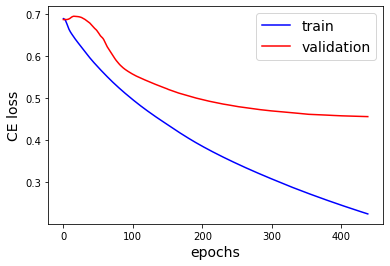

In [15]:
plt.plot(train_losses,'b',label='train')
plt.plot(val_losses,'r',label='validation')
plt.legend(fontsize=14)
plt.xlabel('epochs',fontsize=14)
plt.ylabel('CE loss',fontsize=14)

In [16]:
# accuracy
from sklearn.metrics import accuracy_score

def acc(net,X,y,text='Accuracy: '):
    net.eval()
    X=X.to(device)
    pred=net(X).cpu()
    y_pred = torch.argmax(pred, dim=1)
    print(text, round(accuracy_score(y, y_pred),2))

acc(net,X_train,y_train,'Train accuracy: ')
acc(net,X_val,y_val,'Validation accuracy: ')

Train accuracy:  0.96
Validation accuracy:  0.92


### Evaluate on the test set

Calculate the accuracy of the network prediction on the test set and compare to training and validation. Does the network generalise well on unseen data?

In [17]:
acc(net,X_test,y_test,'Test accuracy: ')

Test accuracy:  0.84


# Optional exercise

Develop similar solution to the problem of classification of cancerous tissue from histological images.

You have seen the dataset already in Chapter 8 (Section Feature Extraction). Download the dataset from https://gin.g-node.org/MachineLearningBiomedApplications/data. Once you have done that you can load it using this code:

In [18]:
import numpy as np

# Load dataset from .npz file
data = np.load('datasets/histological_data.npz')

# Train images and labels
X_train = data['X_train']
y_train = data['y_train'].astype('int')

# Test images and labels
X_test  = data['X_test']
y_test  = data['y_test'].astype('int')

# Print shapes here
print('Training data - images:', X_train.shape)
print('Training data - labels:',y_train.shape)
print('Test data - images:',X_test.shape)
print('Test data - labels:',y_test.shape)
print('Labels: ', np.unique(y_test))

Training data - images: (1500, 96, 96)
Training data - labels: (1500,)
Test data - images: (150, 96, 96)
Test data - labels: (150,)
Labels:  [0 1]


Now create and train a CNN that will predict the labels (malignant and benign) from the histological images. This is an open ended exercise, so no solution is given. However, you can benchmark the performance of your network based on the classifier implemented in notebook *8.1. Feature Extraction.ipynb*